# Libraties

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data preparation

In [ ]:
!unzip /content/drive/MyDrive/CV++/captcha_data/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/YPijd.jpg          
  inflating: data/Ypik1.jpg          
  inflating: data/ypikS.jpg          
  inflating: data/Ypimj.jpg          
  inflating: data/YPiNH.jpg          
  inflating: data/YpiPj.jpg          
  inflating: data/YPIVJ.jpg          
  inflating: data/YPJ3E.jpg          
  inflating: data/yPJi4.jpg          
  inflating: data/yPJuY.jpg          
  inflating: data/ypkED.jpg          
  inflating: data/YPkMD.jpg          
  inflating: data/YPKO6.jpg          
  inflating: data/ypLCF.jpg          
  inflating: data/Yplf4.jpg          
  inflating: data/yplFR.jpg          
  inflating: data/YPLgL.jpg          
  inflating: data/YplYE.jpg          
  inflating: data/ypmbZ.jpg          
  inflating: data/YPMFn.jpg          
  inflating: data/YPmkV.jpg          
  inflating: data/YPMQF.jpg          
  inflating: data/yPMY4.jpg          
  inflating: data/YPnhR.jpg          
  inflating: data/YPnP4.jpg          

## Setup

In [ ]:
import random

# Path to the data directory
data_dir = Path("/content/data")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Random image: ", random.choice(images))
print("Number of labels found: ", len(labels))
print("Random label: ", random.choice(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 150
img_height = 40

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  113062
Random image:  /content/data/lywju.jpg
Number of labels found:  113062
Random label:  dSBR7
Number of unique characters:  60
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    val_samples = int(size * (train_size + val_size))
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:val_samples]], labels[indices[train_samples:val_samples]]
    x_test, y_test = images[indices[val_samples:]], labels[indices[val_samples:]]
    return x_train, x_valid, x_test, y_train, y_valid, y_test

def k_fold_data(images, labels, partition_size=0.1, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    partition = int(size * partition_size)
    # 4. Split data into training and validation sets
    dataset_partitions = []
    for i in range (int(partition_size * 100)):
        x_set, y_set = images[indices[partition * i:partition * (i + 1)]], labels[indices[partition * i:partition * (i + 1)]]
        dataset_partitions.push(tuple([x_set, y_set]))
    return dataset_partitions


# Splitting data into training and validation sets
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_jpeg(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

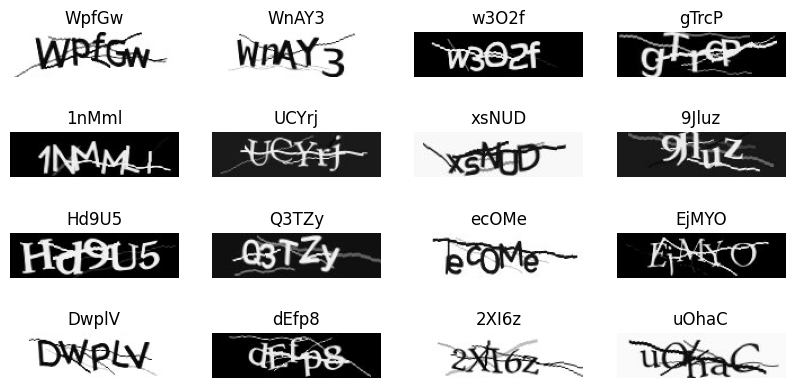

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

Model: "captcha_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 150, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 40, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 75, 20, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 75, 20, 64)   18496       ['pool1[0][0]']      

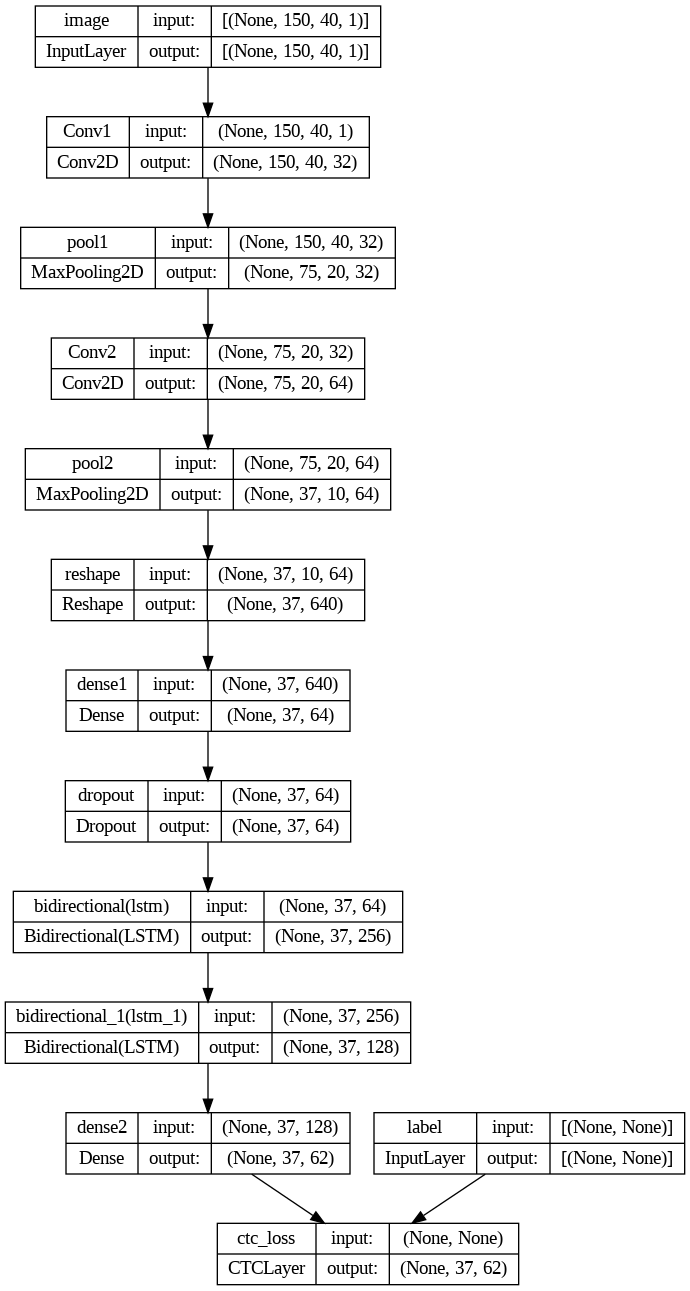

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        #CTC
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        #Loss = -log(sum of probabilities)
        #Probability Sum = 10^(-Loss)
        self.add_metric(10**(-loss), name='accuracy')

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        #Change name if it is already taken
        inputs=[input_img, labels], outputs=output, name="captcha_model"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Trực quan hóa mô hình và lưu ảnh với kích thước hình chữ nhật nằm ngang
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=300, bbox_inches='tight')

In [ ]:
import shutil

In [ ]:
#Training
epochs = 50
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

model.save('latest_model')

Epoch 1/50
5654/5654 [==============================] - 185s 33ms/step - loss: 11.6962 - accuracy: 1.0571e-07 - val_loss: 9.4708 - val_accuracy: 1.7737e-06
Epoch 2/50
5654/5654 [==============================] - 187s 33ms/step - loss: 9.5145 - accuracy: 8.9600e-06 - val_loss: 7.6508 - val_accuracy: 1.0004e-04
Epoch 3/50
5654/5654 [==============================] - 184s 32ms/step - loss: 8.1235 - accuracy: 1.1194e-04 - val_loss: 6.5334 - val_accuracy: 8.0873e-04
Epoch 4/50
5654/5654 [==============================] - 188s 33ms/step - loss: 7.1744 - accuracy: 6.0724e-04 - val_loss: 5.7243 - val_accuracy: 0.0028
Epoch 5/50
5654/5654 [==============================] - 195s 34ms/step - loss: 6.4938 - accuracy: 0.0018 - val_loss: 5.0645 - val_accuracy: 0.0072
Epoch 6/50
5654/5654 [==============================] - 184s 33ms/step - loss: 5.9951 - accuracy: 0.0043 - val_loss: 4.7226 - val_accuracy: 0.0139
Epoch 7/50
5654/5654 [==============================] - 192s 34ms/step - loss: 5.6092 - a

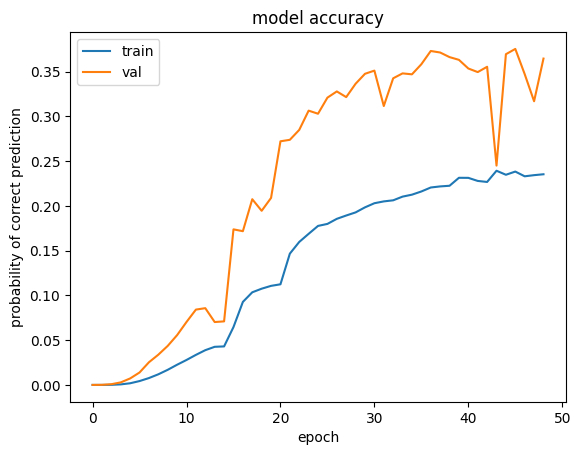

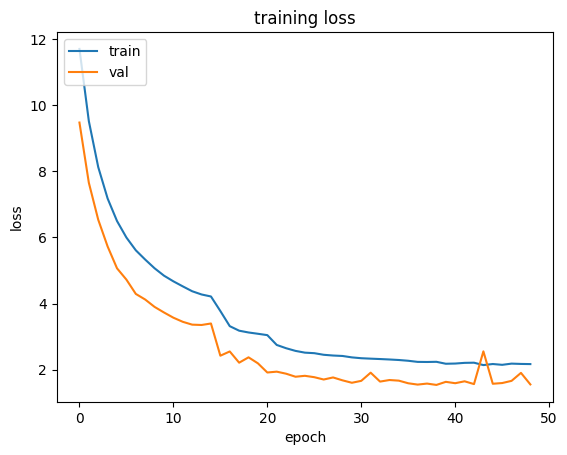

In [ ]:
#Plot Results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('probability of correct prediction')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Sanity check to ensure the latest_model exists
path = '/content/latest_model'
os.path.exists(path)

1/1 [==============================] - 1s 1s/step


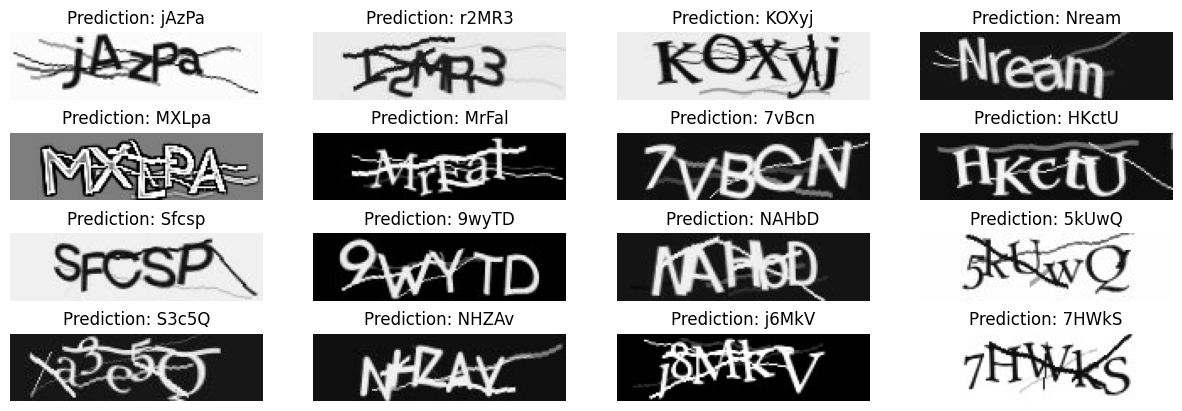

In [ ]:
# Get the prediction model by extracting layers till the output layer
path = '/content/latest_model'

prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
#prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

1/1 [==============================] - 2s 2s/step


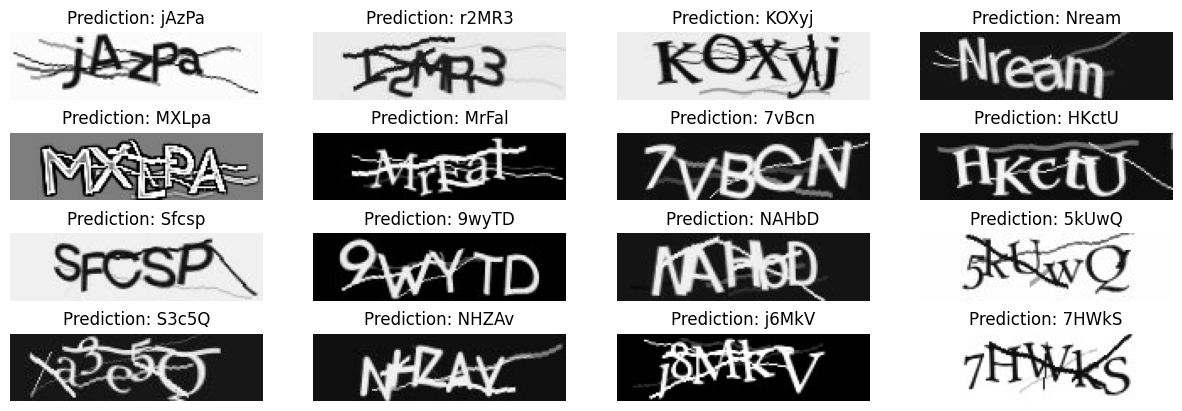

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Tải mô hình đã lưu
loaded_model = tf.keras.models.load_model('/content/latest_model')

# Trích xuất các tầng từ mô hình gốc
input_layer = loaded_model.get_layer(name="image").input
output_layer = loaded_model.get_layer(name="dense2").output

# Tạo mô hình dự đoán
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
#prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()
